Visoelastic Data Viewer

In [ ]:
from pvc_tensile_experiment.Functions import *

# set desired plasticizer
for plastiRatio in ['P2']:#, 'P4', 'P6', 'P8']:
   ViscoelasticDataViewer(plastiRatio)


Stress Relaxation Parameter Boundary Estimation

In [ ]:
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *


modelBoundaries = list([[(1e4, 1e6), (1e4, 10e6), (50, 150)], # SLS
                        [(1e4, 1e6), (1e5, 5e6), (1, 150), (4e4, 12e4), (250, 1000)], # Proney 2 term
                        [(1e4, 1e6), (1e5, 5e6), (1, 150), (4e4, 12e4), (20, 100), (4e4, 12e4), (250, 400)] # Proney 3 term
                        ])


def ViscoelaticFitting(modelBoundaries, plastiRatio):
    # these equations are normalized to stress/strain
    def SLS(params, t):
        EInf, E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        EInf, E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def StressRelaxationRegionSelector(strainRate):
        # find the increasing strain regions
        startIndices = np.where(np.diff(strainRate) > 3e-3)[0]
        startIndices = np.delete(startIndices, np.where(np.diff(startIndices) == 1)) - 5
        startIndices = np.delete(startIndices, 0)
        startIndices = np.insert(startIndices, 0, 1)

        # get the end indices based on the points before the start of the next region
        endIndices = np.array([startIndices[1] - 50, startIndices[2] - 50, len(strainRate) - 130])
        regions = np.array([startIndices, endIndices])
        return regions

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the model fitting function
    def FitModel(model, t, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, t) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.sqrt(np.mean(stress**2))

        # run the genetic algorithm first and use the results for the levenberg-marquardt solution
        optParams = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 200).x
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLS, modelBoundaries[0]),
        "Prony 2-Term Model": (Prony2Term, modelBoundaries[1]), 
        "Prony 3-Term Model": (Prony3Term, modelBoundaries[2])
        }

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 4])

    # define a dictionary to store the model coefficient
    fitResults = {}

    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])
        
        for i in fileNames:
            # read and process the data file for strain and stress 
            expTime, strain, strainRate, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
            regions = StressRelaxationRegionSelector(strainRate)

            for j in range(0, 3):
                # extract the increasing strain regions
                indexRange = range(regions[0, j], regions[1, j])
                expTimeFit = expTime[indexRange] - expTime[indexRange][0]
                strainFit = strain[indexRange] - strain[indexRange][0]
                stressFit = stress[indexRange] - stress[indexRange][0]

                # find indices that create non values for the normalized stress
                indexRemoval = ~np.isnan(stressFit/strainFit)

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([expTimeFit[indexRemoval], strainFit[indexRemoval], stressFit[indexRemoval], stressFit[indexRemoval]/strainFit[indexRemoval]]).T])

                # fit each data set for normalized stress
                params = FitModel(model, expTimeFit[indexRemoval], stressFit[indexRemoval]/strainFit[indexRemoval], boundaries)
                FitCoefficients = np.vstack([FitCoefficients, params])

            
        # average the fitted coefficients and store them
        fitResults[name] = (np.average(FitCoefficients, axis = 0))

        # show the results
        print(name, params, '\n')

    # sort data based on time 
    Data = Data[Data[::, 0].argsort()]

    # remove indicies where the normalized stress is way overshot, and are less than zero 
    Data = np.delete(Data, np.where(Data[::, 3] >= np.mean(Data[::, 3]) + 3*np.std(Data[::, 3]))[0], axis = 0)
    Data = np.delete(Data, np.where(Data[::, 3] < 0.1)[0], axis = 0)

    # define the resulting vectors
    expTimeFit = Data[::, 0]
    strainFit = Data[::, 1]
    stressFit = Data[::, 2]
    normStress = Data[::, 3]

    # plot the fitment region
    plt.scatter(expTimeFit, normStress, s = markerSize, label = f'{plastiRatio} Test Data')

    # plot the model
    for name, (params) in fitResults.items():
        print(RSquared(Data[::, 3], models[name][0](params, Data[::, 0])))
        plt.scatter(Data[::, 0], models[name][0](fitResults[name], Data[::, 0]), s = markerSize, label = f'{name}')#, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Strain (m/m)', fontsize = axisSize)
        plt.ylabel('Stress (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)

    plt.ylim([0, 0.1e7])

plastiRatio ='P2'
ViscoelaticFitting(modelBoundaries, plastiRatio)

Viscoelastic Monotonic Strain Rate Fitting

SLS Model [61360.36041383   600.88754374] 

Prony 2-Term Model [1.72374717e+05 1.13001157e+01 5.58031850e+04 2.53740142e+02] 

Prony 3-Term Model [1.12644823e+05 3.38397687e+00 7.91131896e+04 3.54084050e+01
 4.40948753e+04 2.63393912e+02] 



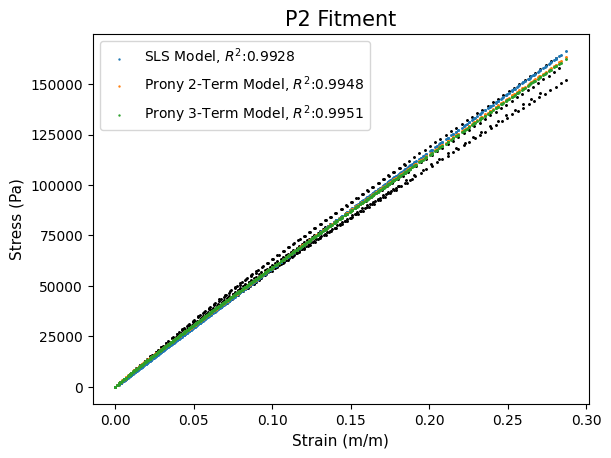

In [7]:
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *

modelBoundaries = list([[(1e4, 1e6), (600, 1000)], # SLS
                        [(1e5, 1e6), (1, 15), (4e4, 12e4), (250, 400)], # Proney 2 term
                        [(1e5, 5e6), (1, 15), (4e4, 12e4), (20, 100), (4e4, 12e4), (250, 400)] # Proney 3 term
                        ])

def ViscoelaticFitting(modelBoundaries, plastiRatio):
    # define the SLS, Prony series, and coefficient of determination functions
    # these are in terms of stress
    def SLSStrainRate(params, strain):
        E1, tau = params
        return EInf*strain + E1*tau*strainRateFit*(1 - np.exp(-strain/(tau*strainRateFit))) 

    def Prony2TermStrainRate(params, strain):
        E1, tau1, E2, tau2 = params

        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))))

    def Prony3TermStrainRate(params, strain):
        E1, tau1, E2, tau2, E3, tau3 = params
        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))) +
                E3*tau3*strainRateFit*(1 - np.exp(-strain/(tau3*strainRateFit))))

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)

    # define the model fitting function
    def FitModel(model, strain, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, strain) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.sqrt(np.mean(stress**2))

        # run the genetic algorithm first and use the results for the levenberg-marquardt solution
        optParams = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 100).x
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLSStrainRate, modelBoundaries[0]),
        "Prony 2-Term Model": (Prony2TermStrainRate, modelBoundaries[1]), 
        "Prony 3-Term Model": (Prony3TermStrainRate, modelBoundaries[2])
        }


    """Equilibrium Determination"""
    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # preallocate a list to store the equilibrium modulus 
    EInf = []

    for i in fileNames:
        # read and process the data file for strain and stress 
        _, strain, strainRate, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
        regions = StressRelaxationRegionSelector(strainRate)
        
        for j in range(0, 3): 
            # use the start and end indices to find the step region and store the equilibrium modulus
            indexRange = range(regions[0, j], regions[1, j])
            strainFit = strain[indexRange] - strain[indexRange][0]
            stressFit = stress[indexRange] - stress[indexRange][0]
            EInf.append(stressFit[-1]/strainFit[-1])

    # convert the equilibrium modulus into an average value
    EInf = np.average(EInf)


    """Monotonic Strain Rate Fitting"""
    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir('Data/Viscoelastic Data/Monotonic Strain Rate Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 3])

    # define a dictionary to store the model coefficient
    fitResults = {}

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])

        # read each file, extracting the increasing strain region and save all to a set of arrays
        for i in fileNames:
            # read and process the data file for strain and stress 
            _, strain, strainRate, stress = ViscoelasticDataProcessor('Monotonic Strain Rate Data', i)

            # find each strain amplitude region
            regions = MonotonicStrainRateRegionSelector(strain)
            
            for j in range(0, 3):
                # extract the increasing strain regions
                indexRange = range(regions[0, j], regions[1, j])
                strainFit = strain[indexRange] - strain[indexRange][0]
                strainRateFit = strainRate[indexRange]
                stressFit = stress[indexRange] - stress[indexRange][0]

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([strainFit, strainRateFit, stressFit]).T])
            
                # plot data results
                plt.scatter(strainFit, stressFit, s = markerSize, color = "black")
                    
                # run the data fitment for increasing strain regions
                # the strainrate for the fitted region applies directly into this function
                # strainRateFit = np.average(strainRate[indexRange])
                params = FitModel(model, strainFit, stressFit, boundaries)
                FitCoefficients = np.vstack([FitCoefficients, params])
            
        # average the fitted coefficients
        params = np.average(FitCoefficients, axis = 0)

        # redefine the strainRateFit from the stored data. its passed to make sure the functions work
        strainRateFit = np.average(Data[::, 1])
        rSquared = RSquared(models[name][0](params, Data[::, 0]), Data[::, 2])
        fitResults[name] = (params, np.round(rSquared, 4))
        
        # show the results
        print(name, params, '\n')

    for name, (params) in fitResults.items():
        plt.scatter(Data[::, 0], models[name][0](fitResults[name][0], Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Strain (m/m)', fontsize = axisSize)
        plt.ylabel('Stress (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Fitment', fontsize = titleSize)
        plt.legend()
    return EInf, fitResults

EInf, fitResults = ViscoelaticFitting(modelBoundaries, 'P2')

Stress Relaxation Verification

C:\Users\facci\AppData\Local\Temp\ipykernel_22552\558241989.py:64: RuntimeWarning: invalid value encountered in divide
  indexRemoval = np.where(Data[::, 2]/Data[::, 1] >= np.mean(Data[::, 2]/Data[::, 1]) + 3*np.std(Data[::, 2]/Data[::, 1]))[0]


0.16925316778391375
0.017969349474299623
-0.0016031098686180023


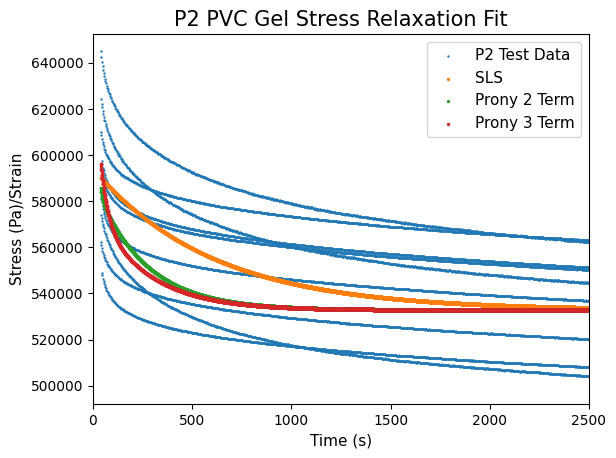

In [8]:
def StressRelaxation(plastiRatio, fitResults):
    # these equations are normalized to stress/strain
    def SLS(params, t):
        E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def StressRelaxationRegionSelector(strainRate):
        # find the increasing strain regions
        startIndices = np.where(np.diff(strainRate) > 3e-3)[0]
        startIndices = np.delete(startIndices, np.where(np.diff(startIndices) == 1)) - 6
        startIndices = np.delete(startIndices, 0)
        startIndices = np.insert(startIndices, 0, 1)

        # get the end indices based on the points before the start of the next region
        endIndices = np.array([startIndices[1] - 50, startIndices[2] - 50, len(strainRate) - 130])
        regions = np.array([startIndices, endIndices])
        return regions

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)

    # define the folder and find the files for strain relaxation
    folderName = 'Stress Relaxation Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # preallocate the total data matrix
    Data = np.zeros([0, 3])

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11
    
    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, strainRate, stress = ViscoelasticDataProcessor(folderName, i)
        regions = StressRelaxationRegionSelector(strainRate)
        
        for j in range(0, 3): 
            # using the index range, find the fitting region and store this data in an array
            indexRange = range(regions[0, j], regions[1, j])
            expTimeFit = expTime[indexRange] - expTime[indexRange][0]
            strainFit = strain[indexRange] - strain[indexRange][0]
            stressFit = stress[indexRange] - stress[indexRange][0]

            # store stress and strain into arrays for data fitting.
            Data = np.vstack([Data, np.array([expTimeFit, strainFit, stressFit]).T])
            
    # sort the data based on time 
    Data = Data[Data[::, 0].argsort()]

    # find indicies that are way overshot, indicating that it's not sufficient
    indexRemoval = np.where(Data[::, 2]/Data[::, 1] >= np.mean(Data[::, 2]/Data[::, 1]) + 3*np.std(Data[::, 2]/Data[::, 1]))[0]
    Data = np.delete(Data, indexRemoval, axis = 0)
    expTimeFit = Data[70:, 0]
    strainFit = Data[70:, 1]
    stressFit = Data[70:, 2]

    # plot the fitment region
    plt.scatter(expTimeFit, stressFit/strainFit, s = markerSize, label = f'{plastiRatio} Test Data')

    # plot the fit results for each function
    plt.scatter(expTimeFit, SLS(fitResults['SLS Model'][0], expTimeFit), s = 2, label = 'SLS')
    print(RSquared(stressFit/strainFit, SLS(fitResults['SLS Model'][0], expTimeFit)))

    plt.scatter(expTimeFit, Prony2Term(fitResults['Prony 2-Term Model'][0], expTimeFit), s = 2, label = 'Prony 2 Term')
    print(RSquared(stressFit/strainFit, Prony2Term(fitResults['Prony 2-Term Model'][0], expTimeFit)))
    
    plt.scatter(expTimeFit, Prony3Term(fitResults['Prony 3-Term Model'][0], expTimeFit), s = 2, label = 'Prony 3 Term')
    print(RSquared(stressFit/strainFit, Prony3Term(fitResults['Prony 3-Term Model'][0], expTimeFit)))

    plt.xlabel('Time (s)', fontsize = axisSize)
    plt.ylabel('Stress (Pa)/Strain', fontsize = axisSize)
    plt.title(f'{fileNames[0].removesuffix('.xlsx').split('_')[0]} Fit', fontsize = titleSize)
    plt.xlim([0, 2500])
    # plt.ylim([0, 1000000])
    # plt.gca().set_ylim(bottom=0)
    plt.legend(fontsize = legendSize)
    return Data

Data = StressRelaxation('P2', fitResults)

MISC. & Old Functions